# Deep K-Means Algorithm

# 1. Library

In [1]:
# 필요한 라이브러리 임포트 
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


# 2. Data Load

In [3]:
batch_size = 500
num_clusters = 2 # k-mean에서는 num cluster를 hyperparameter로 정의
latent_size = 64 # latent vector size

In [4]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

In [5]:
def process_data(df) -> pd.DataFrame:
    numeric_cols = [
        'xmeas_1', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
        'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_2',
        'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25',
        'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_3', 'xmeas_30',
        'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
        'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_4', 'xmeas_40', 'xmeas_41',
        'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmv_1',
        'xmv_10', 'xmv_11', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6',
        'xmv_7', 'xmv_8', 'xmv_9'
    ]
    return df[numeric_cols]

In [6]:
X_train = process_data(train_data)
X_test = process_data(test_data)

In [7]:
def create_new_features(df):
    # 새로운 feature를 저장할 딕셔너리
    new_features = {}
    
    # xmeas_1부터 xmeas_8까지 반복
    for i in range(1, 9):
        # xmv_i - xmeas_* 계산하여 새로운 feature 생성
        for j in range(1, 42):
            new_feature_name = f'{i}_{j}'
            new_features[new_feature_name] = df[f'xmv_{i}'] - df[f'xmeas_{j}']
    # 딕셔너리를 데이터프레임으로 변환하여 반환
    return pd.DataFrame(new_features)
    

In [8]:
new_train = create_new_features(X_train)
new_test = create_new_features(X_test)

In [9]:
new_train = pd.concat([train_data, new_train], axis=1)
new_test = pd.concat([X_test, new_test], axis=1)

# # 'simple'과 'simulationRun' 열 삭제
# new_test = new_test.drop(columns=['simple', 'simulationRun'])

In [10]:
# 데이터셋을 simulationRun을 기준으로 분할하는 함수 정의
def split_dataset_by_simulation(data):
    unique_simulation_runs = data['simulationRun'].unique()
    train_simulation_runs = unique_simulation_runs[:475]  # 처음 400개를 학습에 사용
    val_simulation_runs = unique_simulation_runs[475:]  # 나머지를 검증에 사용
    
    train_data = data[data['simulationRun'].isin(train_simulation_runs)].drop(columns=['simulationRun','sample','faultNumber'])
    val_data = data[data['simulationRun'].isin(val_simulation_runs)].drop(columns=['simulationRun','sample','faultNumber'])
    
    return train_data, val_data

In [11]:
# 데이터 분할
X_train, X_val = split_dataset_by_simulation(new_train)

# 데이터 스케일러 인스턴스 생성(데이터 표준화)
scaler = StandardScaler() 

# 학습 데이터셋에 대해 fit과 transform 수행: train 기준 정보 계산 및 데이터 변환
X_train_scaled = scaler.fit_transform(X_train) 
X_val_scaled = scaler.transform(X_val)

# PyTorch Tensor로 변환 
X_train_tensor = torch.FloatTensor(X_train_scaled) 
X_val_tensor = torch.FloatTensor(X_val_scaled)

# DataLoader 설정 
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # 입력과 타겟이 같음
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)  # 입력과 타겟이 같음
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
# test 데이터셋
# 테스트 데이터셋에 대해서는 transform만 수행: 학습 데이터셋의 기준 정보를 사용하여 데이터 변환
X_test_scaled = scaler.fit_transform(new_test)  
X_test_tensor = torch.FloatTensor(X_test_scaled)  

In [13]:
# 데이터 형식 확인 
for data in train_loader:
    inputs = data[0]  # 첫 번째 요소가 입력 데이터
    targets = data[1]  # 두 번째 요소가 타겟 데이터
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    # 여기에 데이터 형식에 대한 추가 확인 또는 시각화 코드 추가 가능
    break  # 첫 번째 배치만 확인

Input shape: torch.Size([500, 380])
Target shape: torch.Size([500, 380])


# 3. 모델 정의 (flatten, deflatten, encoder, decoder, kmeans)

In [25]:
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        
        k = 16
        self.encoder = nn.Sequential(
            nn.Linear(380, 256), 
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(256, 128), 
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(128, latent_size), 
            nn.ReLU(), # 활성화 함수 ReLU 사용
            # nn.Linear(64, latent_size), 
            # nn.ReLU(), # 활성화 함수 ReLU 사용
            # nn.Linear(32, latent_size), # 중간 차원 32에서 중간 차원 16로 압축
            # nn.ReLU(), # 활성화 함수 ReLU 사용
            # nn.Linear(16, latent_size), # 중간 차원 16에서 특징 차원 8으로 더 압축
            # nn.ReLU(), # 활성화 함수 ReLU 사용
        )

    def forward(self, x):       
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        
        k = 16
        self.decoder = nn.Sequential(
            # nn.Linear(latent_size, 16), # 특징 차원 8에서 중간 차원 16로 확장
            # nn.ReLU(), # 활성화 함수 ReLU 사용
            # nn.Linear(latent_size, 32), # 중간 차원 16에서 중간 차원 32로 확장
            # nn.ReLU(), # 활성화 함수 ReLU 사용
            # nn.Linear(latent_size, 64),
            # nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(latent_size, 128),
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(128, 256),
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(256, 380),
            nn.Sigmoid() # 출력을 0과 1 사이로 조정
        )
    
    def forward(self, x):       
        return self.decoder(x)
        
class Kmeans(nn.Module): 
    def __init__(self, num_clusters, latent_size):
        super(Kmeans, self).__init__()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.num_clusters = num_clusters
        self.centroids = nn.Parameter(torch.rand((self.num_clusters, latent_size)).to(device))
    
    def argminl2distance(self, a, b): # L2 distance   
        return torch.argmin(torch.sum((a-b)**2,dim=1),dim=0)
    
    # def argmin_manhattan_distance(self, a, b): # Manhattan Distance
    #     return torch.argmin(torch.sum(torch.abs(a - b), dim=1), dim=0)

    # def argmin_euclidean_distance(self, a, b): # Euclidean Distance
    #     return torch.argmin(torch.sqrt(torch.sum((a - b)**2, dim=1)), dim=0)

    # def argmin_chebyshev_distance(self, a, b): # Chebyshev Distance
    #     return torch.argmin(torch.max(torch.abs(a - b), dim=1).values, dim=0)

    def forward(self, x):
        y_assign = []
        for m in range(x.size(0)):
            h = x[m].expand(self.num_clusters,-1)
            assign = self.argminl2distance(h, self.centroids)
            y_assign.append(assign.item())
        
        return y_assign, self.centroids[y_assign]

# 4. clustering accuracy func justice

In [26]:
def cluster_acc(y_true, y_pred):

    y_true = np.array(y_true, dtype=np.int64)  # numpy 배열로 변환
    y_pred = np.array(y_pred)  # 수정되지 않음

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    
    return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size
         
def evaluation(testloader, encoder, kmeans, device):
    predictions = []
    actual = []

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            latent_var = encoder(inputs)
            y_pred, _ = kmeans(latent_var)  # 클러스터링 결과

            predictions += y_pred
            actual += labels.tolist()

    return cluster_acc(actual, predictions)

# 5. loss and optimization

In [27]:
encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)
kmeans = Kmeans(num_clusters, latent_size).to(device)

# Loss and optimizer
criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(list(encoder.parameters()) + 
                              list(decoder.parameters()) +
                              list(kmeans.parameters()), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# ReduceLROnPlateau는 손실이 더 이상 개선되지 않을 때 학습률을 감소시키는 방법을 제공

In [28]:
# Training
T1 = 50
T2 = 200
lam = 1e-3
ls = 0.05

In [30]:
for ep in range(300):
    if (ep > T1) and (ep < T2):
        alpha = lam*(ep - T1)/(T2 - T1) # 1/100, 2/100, .., 99/100
    elif ep >= T2:    
        alpha = lam
    else:
        alpha = lam/(T2 - T1)
        
    running_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.to(device)  # 데이터를 디바이스로 이동
        
        optimizer.zero_grad()
        latent_var = encoder(inputs)
        _, centroids = kmeans(latent_var.detach())
        outputs = decoder(latent_var)
        
        l_rec = criterion1(inputs, outputs) 
        l_clt = criterion2(latent_var, centroids) 
        loss = l_rec + alpha*l_clt
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
  
    avg_loss = running_loss / len(train_loader)        
    
    if ep % 1 == 0:               
        testacc = evaluation(val_loader, encoder, kmeans, device)
        print('[%d] Train loss: %.4f, Val Accuracy: %.3f' %(ep, avg_loss, testacc))  
        
    if avg_loss < ls:
        ls = avg_loss
        torch.save(encoder.state_dict(),'./models/dkm5_en.pth')
        torch.save(decoder.state_dict(),'./models/dkm5_de.pth')
        torch.save(kmeans.state_dict(),'./models/dkm5_clt.pth')

[0] Train loss: 0.7148, Val Accuracy: 1.000
[1] Train loss: 0.6863, Val Accuracy: 1.000
[2] Train loss: 0.6817, Val Accuracy: 1.000
[3] Train loss: 0.6788, Val Accuracy: 1.000
[4] Train loss: 0.6760, Val Accuracy: 1.000
[5] Train loss: 0.6736, Val Accuracy: 1.000
[6] Train loss: 0.6723, Val Accuracy: 1.000
[7] Train loss: 0.6708, Val Accuracy: 1.000
[8] Train loss: 0.6700, Val Accuracy: 1.000
[9] Train loss: 0.6693, Val Accuracy: 1.000
[10] Train loss: 0.6688, Val Accuracy: 1.000
[11] Train loss: 0.6683, Val Accuracy: 1.000
[12] Train loss: 0.6679, Val Accuracy: 1.000
[13] Train loss: 0.6678, Val Accuracy: 1.000
[14] Train loss: 0.6669, Val Accuracy: 1.000
[15] Train loss: 0.6660, Val Accuracy: 1.000
[16] Train loss: 0.6655, Val Accuracy: 1.000
[17] Train loss: 0.6654, Val Accuracy: 1.000
[18] Train loss: 0.6652, Val Accuracy: 1.000
[19] Train loss: 0.6650, Val Accuracy: 1.000
[20] Train loss: 0.6649, Val Accuracy: 1.000
[21] Train loss: 0.6647, Val Accuracy: 1.000
[22] Train loss: 0.6

KeyboardInterrupt: 

# 6. 모델 결과 확인

In [31]:
predictions = []
actual = []
latent_features = []

with torch.no_grad():
    for data in val_loader:  # 테스트 데이터셋의 배치마다 반복
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        latent_var = encoder(inputs)  # 입력 데이터를 인코더에 통과시켜 잠재 변수를 추출
        y_pred, _ = kmeans(latent_var)  # 클러스터링 결과
        
        predictions += y_pred  # 예측된 클러스터를 리스트에 추가
        latent_features += latent_var.cpu().tolist()  # 잠재 변수를 리스트에 추가
        actual += labels.tolist()  # 실제 레이블을 리스트에 추가

print(cluster_acc(actual, predictions))  # 클러스터링 정확도 계산 및 출력

1.0


In [32]:
# 모델을 평가 모드로 설정
encoder.eval()
kmeans.eval()

# 테스트 데이터셋을 디바이스로 이동
X_test_tensor = X_test_tensor.to(device)

# 테스트 데이터셋을 모델에 전달하여 추론
with torch.no_grad():
    latent_var_test = encoder(X_test_tensor)  # 테스트 데이터셋의 잠재 변수 추출
    y_pred_test, _ = kmeans(latent_var_test)  # 클러스터링 결과

# y_pred_test가 리스트 형식이므로 텐서로 변환
y_pred_test = torch.tensor(y_pred_test)

# 결과를 CSV 파일로 저장
results = pd.DataFrame({'faultNumber': y_pred_test.cpu().numpy()})
results.to_csv('deepkmeans_1.csv', index=False)

In [168]:
results.describe()

,faultNumber
count,710400.000000
mean,0.067572
std,0.251010
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [33]:
merged_df = pd.concat([test_data, results], axis=1)
counts = merged_df[merged_df['faultNumber']==1].groupby('simulationRun').size()
print(counts)
print(counts.describe())


simulationRun
0      333
1      325
2      349
3      304
4      309
      ... 
735    330
736    314
737    839
738    816
739    356
Length: 740, dtype: int64
count    740.000000
mean     423.258108
std      181.811162
min      278.000000
25%      326.750000
50%      340.000000
75%      381.000000
max      866.000000
dtype: float64


In [35]:
less_than_500 = counts[counts > 381].index.tolist()
print(len(less_than_500))
# less_than_500에 해당하는 simulationRun의 faultNumber를 1로, 나머지는 0으로 설정
merged_df['faultNumber'] = merged_df['simulationRun'].apply(lambda x: 1 if x in less_than_500 else 0)
merged_df['faultNumber'].to_csv("deepkmeans_1edit.csv")
print(merged_df['faultNumber'] .value_counts())

184
faultNumber
0    533760
1    176640
Name: count, dtype: int64


Text(0.5, 1.0, 'reconstruction error distribution')

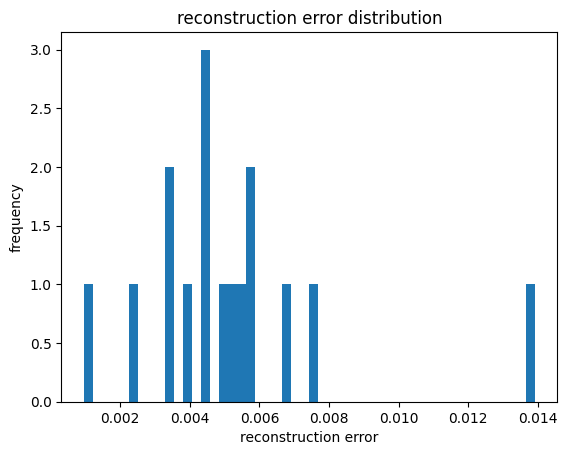

In [22]:
import matplotlib.pyplot as plt  

# reconstruction error 계산 
reconstruction_errors = torch.mean((outputs - inputs) ** 2, axis=1).detach()  #MSE

# reconstruction error 히스토그램 시각화 
plt.hist(reconstruction_errors.numpy(), bins=50) 
plt.xlabel('reconstruction error') 
plt.ylabel('frequency') 
plt.title('reconstruction error distribution')